# Práctica 1 - Clasificación de palabras

## Introducción
El problema que se nos plantea en esta práctica es la clasificación, mediante un modelo basado en SVM, de las palabras de un dataset según la lengua a la que pertenecen. En primera instáncia solamente tenemos palabras del catalán y el inglés, pero se pueden añadir más palabras de otros idiomas usando librerías como [Googletrans](https://www.thepythoncode.com/article/translate-text-in-python#:~:text=Googletrans%20is%20a%20free%20and,detect%20languages%20and%20translate%20text.). 

In [129]:
from itertools import starmap

# Misc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import mean
from matplotlib.colors import ListedColormap
import sklearn.preprocessing
from sklearn.model_selection import train_test_split

# CrossValidation
## K-folding
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

## GridSearch
from sklearn.model_selection import GridSearchCV

# Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

#https://scikit-learn.org/stable/modules/model_evaluation.html

# Model
from sklearn.svm import SVC

## Preparación de los datos
En esta primera parte de la práctica vamos a preparar los datos para poder hacer la clasificación. Para ello haremos que cada muestra siga el siguiente formato: $C_1$ | $C_2$ | $C_3$ | .. | $C_n$ | $y$  (siendo $C$ una característica y $y$ el target).

Se va a codificar $y$ con los valores "0" para representar la clase _anglés_ y "1" para la clase _català_. Si añadieramos más idiomas, simplemente seguiríamos con este formato, siendo por ejemplo _francés_ "2", _alemán_ "3", etc. Esto se conoce como [Label Encoding](https://towardsdatascience.com/categorical-encoding-using-label-encoding-and-one-hot-encoder-911ef77fb5bd). Este tipo de codificación de variables categóricas nos viene como anillo al dedo, ya que no puede dar lugar a la confusión de que los números representan una jerarquía, debido a que estamos tratando con lenguas modernas (la jerarquía podría indicar lo cerca que está esa lengua de su lengua madre, el latín por ejemplo). 

La otra opción sería llevar a cabo Hot Encoding, lo que supondría crear más variables $y$ con los valores 1 y 0 para indicar si pertenece una palabra a un idioma. Esta aproximación nos podría acabar incrementando muchísimo la dimensionalidad del problema.

In [130]:
#Auxiliar function that reformats df to one that is more fitting to Classification Problems
def reformat(dataFrame):
    dataFrame['y']=dataFrame.columns[0]
    
    dataFrame.rename(columns={dataFrame.columns[0]: 'word'}, inplace=True)
    return dataFrame

#RawData, it has been a bit formatted before reading the csv, to facilitate the process.
raw=pd.read_csv("data/data.csv")
#Split df
catala, angles= raw.filter(['catala'], axis=1), raw.filter(['angles'], axis=1)
#Reformating
catala=reformat(catala)
angles=reformat(angles)

#Merging
wordsDF=pd.concat([catala,angles], axis=0)

#Encoding variables
wordsDF['y']=wordsDF['y'].astype('category')
wordsDF['y']=wordsDF['y'].cat.codes
#Shuffle the rows
wordsDF = wordsDF.sample(frac=1).reset_index(drop=True)



## Soluciones consideradas

### Caracterísiticas
Las características que hemos pensado que pueden ser útiles para la clasificación de las palabras son:
- Cantidad de caracteres (Númerica)
- Proporción de consonantes por vocal (consonantes / vocales) (Numérica)
- Contiene patrones o normas ortográficas de una lengua de las que vamos a clasificar?
    + Doble uso de vocal consecutivamente como es el caso del inglés (Categórica)
    + Acentos en caso de catalán (Categórica)
    + Contiene combinaciones de consonantes (consonant clusters) propias del inglés? (Categórica)

Referencias
- <[Consonant_Clusters](https://www.aprendeinglessila.com/2013/09/consonantes-ingles-clusters)>
- <[Digraphs, Trigraphs, Quadraphs](https://thereadingadvicehub.com/trigraphs-and-quadgraphs-tetragraphs/)>
- <[Frecuencia_De_Letras_Usadas_En_Catalan](https://es.sttmedia.com/frecuencias-de-letras-catalan)>
- <[Frecuencia_De_Letras_Usadas_En_Catalan](https://www3.nd.edu/~busiforc/handouts/cryptography/letterfrequencies.html)>

Para añadir las columnas que representen estas características, hemos aplicado las siguientes funciones a las palabras.

In [131]:
#ratio de consonantes y vocales
def ratio (word):
    vocals=0
    for c in word:
        if isVocal(c):
            vocals+=1
    return round(vocals/len(word), 4)

#isVocal?
def isVocal(c):
    if(c=='a' or c=='e' or c=='i' or c=='o' or c=='u'):
        return True
    return 
#gotAccent?
def gotAccent(word):
    #List containing all possible accentuated chars from Catalan
    ocurrences=[ord('à'),ord('è'),ord('é'),ord('í'),ord('ò'),ord('ó'),ord('ú')]
    for c in word:
        if ord(c) in ocurrences:
            return 1
    return 0
#DoubleVocal?
def doubleVocal(word):
    ocurrences=["aa","ee","ii","oo","uu"]
    for oc in ocurrences:
        if word.find(oc)!=-1:
            return 1
    return 0
#Does it have an english consonant cluster?
def enCC(word):
    ocurrences=["sch","spl","shr","squ","thr","spr","scr","sph","igh","tch","th","tw","ch","ck","kn","ph","sh","wh","wr","sw","sk","sm","tt","pp","bb","dd","ff","gg","vv","ww","zz"]
    for oc in ocurrences:
        if word.find(oc)!=-1:
            
            return 1
    return 0
#Does it have a catalan
def gotCedilla(word):
    ocurrences=["ç"]
    for oc in ocurrences:
        if word.find(oc)!=-1:
            return 1
    return 0

#Features Adding
wordsDF['ratio']=wordsDF['word'].apply(ratio)
wordsDF['cantidadLetras']=wordsDF['word'].apply(len)
wordsDF['gotAccent']=wordsDF['word'].apply(gotAccent)
wordsDF['gotCedilla']=wordsDF['word'].apply(gotCedilla)
wordsDF['doubleVocal']=wordsDF['word'].apply(doubleVocal)
wordsDF['enCC']=wordsDF['word'].apply(enCC)
#Reorganize DF
wordsDF=wordsDF[['word','ratio','cantidadLetras','gotAccent','gotCedilla','doubleVocal','enCC','y']]
#Write DF to csv
wordsDF.to_csv('data/definitiveData.csv', index=False)


### Métricas
Dado que el problema que tenemos delante es uno de clasificación, las métricas que nos serán más útiles son:
- __Accuracy__ (Exactitud): Métrica que mide la proporción de predicciones correctas. Esto se hace haciendo la división entre las predicciones correctas entre el total de predicciones realizadas. Esta métrica suele ser útil en conjuntos de datos donde las clases están distribuidas de manera equilibrada, como en nuestro caso. 
- __Precision__ (Precisión): Métrica que mide la proporción de verdaderos positivos entre todos los positivos ( _TP_ y _FP_ ) detectados por el modelo. Normalmente se utiliza cuando se quiere evitar la detección de falsos positivos, como podría ser en testeos médicos. En esta práctica no se nos especifíca la importancia que habría en evitar falsos positivos, pero aún así usaremos esta métrica con fines de estudio.
- __Recall__ (Sensibilidad): Métrica que mide la proporción de verdaderos positivos detectados entre los positivos que realmente existen ( _TP_ y _FN_ ). Esta métrica se utiliza cuando es importante evitar falsos negativos, pero al igual que la métrica anterior, lo usaremos por fines académicos. 

Por último indicar que también se usará una matriz de confusión para mostrar los resultados de una manera más gráfica. 

### Separación del conjunto de datos en entrenamiento y test
Vamos a escoger dos tercios para el conjunto de entrenamiento y el resto para el test.
 Puntualizar que se han normalizado los datos para un mejor rendimiento del modelo. Solo se han escalado los datos numéricos, ya que sería erróneo escalar todo el dataset, con los categóricos, ya que podría dar lugar a dar menos importancia a estos últimos. 

 En esta sección se preparan los conjuntos de datos para realizar los experimentos 1, 2 y 3.

In [132]:
#First we must separate dataframe into X and y format
X=wordsDF.iloc[:,1:7]
y=wordsDF.iloc[:,7]

#Auxiliar portion of observations set, with only numerical values
X_aux=wordsDF.iloc[:,1:3]


#For better perfomance, we scale the data using a standard scaler
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(X_aux)
standardData_Aux = scaler.transform(X_aux)

#Standarized DF
standardData=X
#Substitute standarized values in correspondent columns
standardData['ratio']=standardData_Aux[:,0]
standardData['cantidadLetras']=standardData_Aux[:,1]


#Only Numerical values dataframe
standardData_Only_Num = standardData.iloc[:,:2]
X_cat = standardData.iloc[:,2:]
#Then we separate the data frame in training and test (will be used in chosen model)
#Experiment 1 train and test
X_train, X_test, y_train, y_test = train_test_split(standardData, y, test_size=0.33, random_state=11)

#Experiment 2 train and test
X_num_train, X_num_test, y_num_train, y_num_test = train_test_split(standardData_Only_Num,y, test_size=0.33, random_state=22)
#Experiment 3 train and test
X_cat_train, X_cat_test, y_cat_train, y_cat_test = train_test_split(X_cat,y,test_size=0.33, random_state=33)

## Experimentos
En este problema creemos que el mejor modelo para clasificar las palabras va a ser una SVM con un kernel gaussiano (__rbf__) ya que tenemos un número de características bastante bajo en comparación al número de muestras. Se han hecho pruebas con un kernel líneal, y si bien los resultados se acercan, el kernel gaussiano ha dado mejores resultados de media.

Los híperparámetros que deberemos de configurar en el modelo del SVM son:
- _C_: El parámetro __C__ en una SVM es un hiperparámetro que controla __la flexibilidad__ del modelo. Se utiliza para controlar el trade-off entre la complejidad del modelo y la cantidad de errores de clasificación que se permiten. Si C es un valor alto, el modelo se vuelve menos flexible y puede tender al overfitting. Si C es un valor bajo, el modelo es más flexible y permite más errores de clasificación. 

- _max\_iter_: __Número máximo de iteraciones__ que se llevará acabo en el entrenamiento del modelo, para encontrar una solución óptima. Si el parámetro es muy pequeño puede que no encuentre una solución óptima y tenga un rendimiento bajo. Por lo contrario si ponemos un valor muy alto podría alargar el tiempo de entrenamiento innecesariamente, ya que una solución óptima se podría encontrar con menos iteraciones.

- _gamma_: Controla el __ancho del kernel__. Cuanto mayor es su valor, menor es el ancho del kernel y viceversa. Si el kernel es muy ancho el modelo se vuelve más suave y no es tan sensible a los detalles de las muestras. 

El resto de híperparámetros no son tan necesarios ya que no se ajustan al problema. (Explicar algún que otro parámetro y decir por qué no es útil).

In [133]:
#Model
SVM_rbf = SVC(kernel='rbf')


## Primer experimento
En el primer experimento, entrenaremos a un modelo basado en SVM con todo el conjunto de características explicado anteriormente. Los resultados que saquemos de este primer experimento, los usaremos como comparación para los siguientes y a raíz de estos sacaremos unas conclusiones.

### Nested Cross-Validation
Para elegir los mejores valores para los híperparámetros y a su vez elegir el modelo que mejor generaliza debemos de hacer uso de la técnica __Nested Cross-validation__. Esta técnica consiste en dos bucles, uno exterior y otro interior:
- En el interior se aplica __GridSearch__, donde se extrae la configuración de híperparámetros que mejores resultados da.
- En el exterior se hace un reentrenamiento con estos híperparámetros y se prueba el modelo con el conjunto de test correspondiente.

Al final del proceso tendremos K modelos, con el score (_accuracy_ normalmente) correspondiente a cada uno.

Referencias:<br>
- <https://ploomber.io/blog/nested-cv/>
- En este artículo se demuestra que hacer solo cross-validation puede resultar en un error de generalización optimista (debido a overfitting) 
<https://jmlr.csail.mit.edu/papers/volume11/cawley10a/cawley10a.pdf>


#### Nested Cross-validation automático

In [134]:
#Hyper Grid
hyper_grid = {"C":[0.1,1,10],"max_iter":[100,1000,10000],"gamma":[.01,.1,1]}
#Inner and Outer crossvalidation, following steps from :
#https://www.analyticsvidhya.com/blog/2021/03/a-step-by-step-guide-to-nested-cross-validation/
# and
# https://inria.github.io/scikit-learn-mooc/python_scripts/cross_validation_nested.html

inner_cv=StratifiedKFold(n_splits=3, shuffle=True)
outer_cv=StratifiedKFold(n_splits=5, shuffle=True)
#GridSearch definition
search=GridSearchCV(estimator=SVM_rbf,cv=inner_cv,param_grid=hyper_grid,scoring="accuracy",n_jobs=-1)

#Test score after nesting
test_score=cross_val_score(search,X_train,y_train,cv=outer_cv,n_jobs=-1)
#search.fit(X_train,y_train)
#Printing results of Nested Cross-Validation
print(f"Mean score of Nested cross-validation:"f"{test_score.mean():.3f}+-{test_score.std():.3f}")
#print(f"The best estimator is:"f"{search.best_estimator_}")

Mean score of Nested cross-validation:0.661+-0.018


#### Nested Cross-Validation manual

In [135]:
#CrossValidation
inner_cv_man=StratifiedKFold(n_splits=3, shuffle=True)
outer_cv_man=StratifiedKFold(n_splits=5, shuffle=True)
best_models = []
best_scores = []
#GridSearch definition
search=GridSearchCV(estimator=SVM_rbf,cv=inner_cv,param_grid=hyper_grid,scoring="accuracy",n_jobs=-1)
aux_X=X_train.to_numpy()
aux_y=y_train.to_numpy()
for train, test in outer_cv_man.split(aux_X,aux_y):
    
    X_train_cv, y_train_cv = aux_X[train], aux_y[train]
    X_test_cv, y_test_cv = aux_X[test], aux_y[test]
    modelo = search.fit(X_train_cv, y_train_cv)
    best_models.append(modelo.best_estimator_)
    best_scores.append(modelo.best_score_)


In [136]:
#Escogemos el mejor modelo obtenido del Nested Cross-validation
modeloExperimento_1 = best_models[best_scores.index(max(best_scores))]
print(modeloExperimento_1)

SVC(C=1, gamma=1, max_iter=1000)


### Prueba del modelo con los parámetros encontrados

Una vez hemos encontrado los mejores híperparámetros para el SVM con Kernel Gaussiano, procedemos a entrenarlo y a realizar la predicción.

Accuracy: 0.674
Precision: 0.667
Recall: 0.665


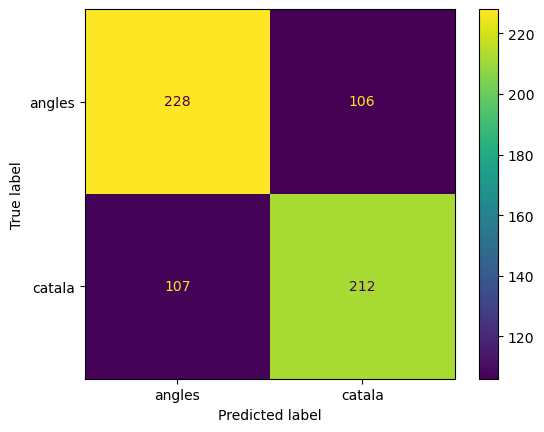

In [137]:
#Re-train Model with Train set
modeloExperimento_1.fit(X_train,y_train)

#Predict with X_test
y_predicted=modeloExperimento_1.predict(X_test)

##Accuracy
print(f"Accuracy: {accuracy_score(y_test,y_predicted):.3f}")

##Precision
print(f"Precision: {precision_score(y_test,y_predicted):.3f}")
#Recall 
print(f"Recall: {recall_score(y_test,y_predicted):.3f}")
#Confussion Matrix
cm=confusion_matrix(y_test,y_predicted, labels=modeloExperimento_1.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["angles","catala"])
disp.plot()
plt.show()

### Conclusiones primer experimento
En este primer experimento, el modelo ha conseguido una __accuracy__ de un 0.669, casi el mismo valor que el inferido del __nested cross-validation__ (0.671). Es un valor de precisión decente, pero podría llegar a aumentarse, por ejemplo, añadiendo características que indiquen el origen de la raíz de una palabra (origen latín o gérmano).<br>
En cuanto a las otras métricas:
- _Precision_: El modelo ha predecido bien un 62.4% del total de muestras que han sido clasificadas como pertenecientes a la clase positiva (catalán en este caso ya que su valor categórico es el 1). 
- _Recall_: En cuanto a la sensibilidad, el modelo ha predecido bien el 69.9% de las muestras la clase positiva, del total real de muestras de la clase positiva.

En cuanto a la matriz de confusión, puntualizar que la función _ConfusionMatrixDisplay_ muestra la matriz en un orden distinto al que estamos acostumbrados. Para más información: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

## Segundo experimento
En este experimento vamos a probar la capacidad de clasificación de un modelo basado en SVM, utilizando solamente las características numéricas. Esto lo haremos para comprobar el peso que tienen realmente estas características respecto a las categóricas que hemos diseñado.

#### Nested Cross-Validation manual

In [138]:
#CrossValidation
inner_cv_man=StratifiedKFold(n_splits=3, shuffle=True)
outer_cv_man=StratifiedKFold(n_splits=5, shuffle=True)
best_models = []
best_scores = []
#GridSearch definition
search=GridSearchCV(estimator=SVM_rbf,cv=inner_cv,param_grid=hyper_grid,scoring="accuracy",n_jobs=-1)
aux_X=X_num_train.to_numpy()
aux_y=y_num_train.to_numpy()
for train, test in outer_cv_man.split(aux_X,aux_y):
    
    X_train_cv, y_train_cv = aux_X[train], aux_y[train]
    X_test_cv, y_test_cv = aux_X[test], aux_y[test]
    modelo = search.fit(X_train_cv, y_train_cv)
    best_models.append(modelo.best_estimator_)
    best_scores.append(modelo.best_score_)


In [139]:
#Escogemos el mejor modelo obtenido del Nested Cross-validation
modeloExperimento_2 = best_models[best_scores.index(max(best_scores))]
print(modeloExperimento_2)

SVC(C=0.1, gamma=1, max_iter=1000)


### Prueba del modelo con los parámetros encontrados

Una vez hemos encontrado los mejores híperparámetros para el SVM con Kernel Gaussiano, procedemos a entrenarlo y a realizar la predicción.

Accuracy: 0.617
Precision: 0.609
Recall: 0.585


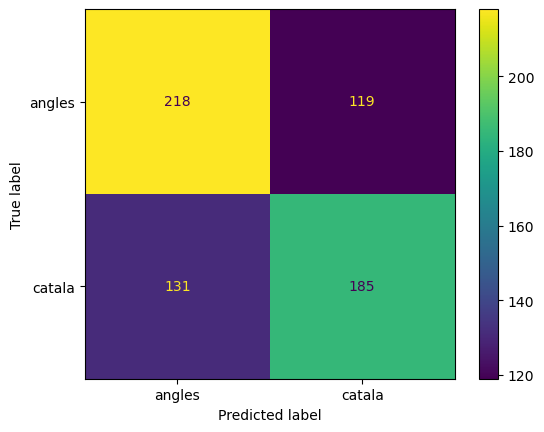

In [140]:
#Re-train Model with Train set
modeloExperimento_2.fit(X_num_train,y_num_train)

#Predict with X_test
y_predicted=modeloExperimento_2.predict(X_num_test)

##Accuracy
print(f"Accuracy: {accuracy_score(y_num_test,y_predicted):.3f}")

##Precision
print(f"Precision: {precision_score(y_num_test,y_predicted):.3f}")
#Recall 
print(f"Recall: {recall_score(y_num_test,y_predicted):.3f}")
#Confussion Matrix
cm=confusion_matrix(y_num_test,y_predicted, labels=modeloExperimento_2.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["angles","catala"])
disp.plot()
plt.show()

### Conclusiones segundo experimento
En este segundo experimento, el modelo ha conseguido una __accuracy__ de un 0.614, un valor significativamente menor que el arrojado en el primer experimento. Puede que se deba a que las variables categóricas sean las más importantes a la hora de hacer la clasificación. Esto será comprobado en el siguiente experimento. En cuanto a las otras métricas:
- _Precision_: El modelo ha predecido bien un 60.0% del total de muestras que han sido clasificadas como pertenecientes a la clase positiva (catalán en este caso ya que su valor categórico es el 1). 
- _Recall_: En cuanto a la sensibilidad, el modelo ha predecido bien el 56.9% de las muestras la clase positiva, del total real de muestras de la clase positiva.

## Tercer experimento
En este experimento vamos a confirmar las sospechas que surgieron tras realizar el segundo experimento: que las variables más importantes en el conjunto diseñado son las categóricas. 

#### Nested Cross-Validation manual

In [141]:
#CrossValidation
inner_cv_man=StratifiedKFold(n_splits=3, shuffle=True)
outer_cv_man=StratifiedKFold(n_splits=5, shuffle=True)
best_models = []
best_scores = []
#GridSearch definition
search=GridSearchCV(estimator=SVM_rbf,cv=inner_cv,param_grid=hyper_grid,scoring="accuracy",n_jobs=-1)
aux_X=X_cat_train.to_numpy()
aux_y=y_cat_train.to_numpy()
for train, test in outer_cv_man.split(aux_X,aux_y):
    
    X_train_cv, y_train_cv = aux_X[train], aux_y[train]
    X_test_cv, y_test_cv = aux_X[test], aux_y[test]
    modelo = search.fit(X_train_cv, y_train_cv)
    best_models.append(modelo.best_estimator_)
    best_scores.append(modelo.best_score_)

In [142]:
#Escogemos el mejor modelo obtenido del Nested Cross-validation
modeloExperimento_3 = best_models[best_scores.index(max(best_scores))]
print(modeloExperimento_3)

SVC(C=1, gamma=0.1, max_iter=1000)


### Prueba del modelo con los parámetros encontrados

Una vez hemos encontrado los mejores híperparámetros para el SVM con Kernel Gaussiano, procedemos a entrenarlo y a realizar la predicción.

Accuracy: 0.510
Precision: 1.000
Recall: 0.121


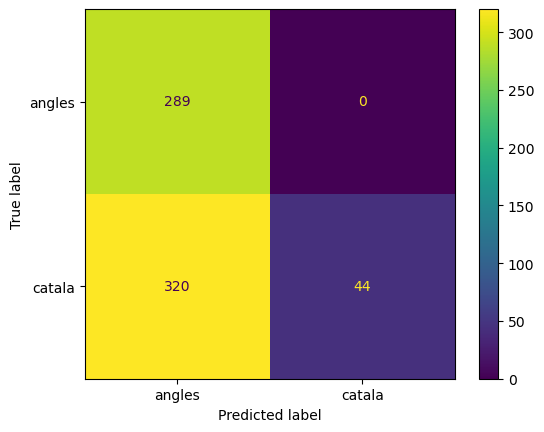

In [143]:
#Re-train Model with Train set
modeloExperimento_3.fit(X_cat_train,y_cat_train)

#Predict with X_test
y_predicted=modeloExperimento_3.predict(X_cat_test)

##Accuracy
print(f"Accuracy: {accuracy_score(y_cat_test,y_predicted):.3f}")

##Precision
print(f"Precision: {precision_score(y_cat_test,y_predicted):.3f}")
#Recall 
print(f"Recall: {recall_score(y_cat_test,y_predicted):.3f}")
#Confussion Matrix
cm=confusion_matrix(y_cat_test,y_predicted, labels=modeloExperimento_2.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["angles","catala"])
disp.plot()
plt.show()

### Conclusiones tercer experimento
En este tercer experimento, el modelo ha conseguido una __accuracy__ de un 0.59, un valor aún menor que el arrojado por el segundo experimento. Lo más interesante lo vemos en las otras métricas:
- _Precision_: El modelo ha predecido bien un 54.4% del total de muestras que han sido clasificadas como pertenecientes a la clase positiva (catalán en este caso ya que su valor categórico es el 1). Esto es un valor realmente bajo, casi equivalente a tirar una moneda al aire. 
- _Recall_: En cuanto a la sensibilidad, el modelo ha predecido "bien" el 99.4% de las muestras la clase positiva, del total real de muestras de la clase positiva. Es decir, que de todas las palabras que eran catalanas, solamente ha dicho que eran inglesas 2. Esto en primera instáncia podría parecer que es un buen valor, pero no lo es.

Con estas métricas podemos inferir que con las características categóricas actuales, el modelo tiene una tendencia a clasificar las palabras como catalanas. La solución podría partir en la mejora de la forma de implementar las características categóricas como _enCC_, donde solamente se verifica si se encuentra el grupo de consonantes en la palabra y no la posición donde es encontrado este grupo. Para ello habría que llevar a cabo una separación por sílabas de la palabra.

También vemos que las características numéricas son más útiles de lo que pensabamos ya que mejoran la clasificación, pero no lo suficiente. Esto es debido a que las categóricas tienen más peso al fin y al cabo, ya que el número de letras y el ratio de consonantes por vocal no son distintivos tan críticos, como pueden ser patrones morfológicos/ortográficos como los explicados en el apartado de características.

## Cuarto experimento
En este experimento vamos a modificar las características que se usaron originalmente para entrenar los modelos. Habiamos hablado de que algunas variables categóricas podian ser modificadas para adquirir una mayor precisión, en concreto _enCC_ que solo indica si se encuentra la combinación de consonantes pero no donde. Así que sustituiremos esa variable por dos variables categóricas, una indica si la combinación de consonantes se encuentra o bien en el principio o en el final de la palabra y la otra variable indica si se encuentra por enmedio. Por supuesto solo una de las dos podrá tener el valor a 1 a la vez porque son mutuamente excluyentes, pero si ambas tienen el valor 0 significa que no se ha encontrado ninguna combinación. Hemos decidido añadir también una variable categórica que indica si una palabra contiene un trígrafo vocal propio del inglés ()

Así pues necesitamos modificar algunas funciones y actualizar el dataset.

In [144]:
def enVocalTrigraph(word):
    ocurrences=["eau","eou","iou"]
    for oc in ocurrences:
        if word.find(oc)!=-1:
            return 1
    return 0
def enGraphs(word):
    ocurrences=["augh","eigh","ngue","ough","our","oor","oul","oar","igh","dge",]
    #Don't matter position
    for oc in ocurrences:
        if word.find(oc)!=-1:
            
            return 1
    #Matter position to ensure it's english
    specialOccurrences=["ore","air","ear","eir"]
    #air ending
    #ore mid word
    #ear mid and beggining
    #eir mid word
    if len(word) > 3 :
        for oc in specialOccurrences:
            index = word.find(oc)
            if index!=-1:
                if oc == "ore":
                    #Found in the middle of the word
                    if index > 0 and index < len(word)-len(oc):
                        
                        return 1
                elif oc == "air":
                    if index == len(word)-len(oc):
                        
                        return 1
                elif oc == "ear":
                    #Foun in the beggining of the word
                    if index == 0:
                        
                        return 1
                    elif index < len(word)-len(oc):
                        
                        return 1
                elif oc == "eir":
                    if index > 0 and index < len(word)-len(oc):
                        
                        return 1

    return 0
def enEnding(word):
    ocurrences=["ing","ate","ify","ide","ise","ize","ed","st","ip","est","ed"]
    for oc in ocurrences:
        index = word.find(oc)
        if(index!=-1):
            if index == len(word)-len(oc):
                return 1
    
    return 0
#Features Adding
wordsDF_Exp = wordsDF
wordsDF_Exp['enVocalTrigraph']=wordsDF_Exp['word'].apply(enVocalTrigraph)
wordsDF_Exp['enGraphs']=wordsDF_Exp['word'].apply(enGraphs)
wordsDF_Exp['enEnding']=wordsDF_Exp['word'].apply(enEnding)

#Reorganize DF
wordsDF_Exp=wordsDF_Exp[['word','ratio','cantidadLetras','gotAccent','gotCedilla','doubleVocal','enCC','enVocalTrigraph','enGraphs','enEnding','y']]
#Write DF to csv
wordsDF_Exp.to_csv('data/definitiveData_Exp.csv', index=False)
#Checking

X = wordsDF_Exp.iloc[:,1:10]
y = wordsDF_Exp.iloc[:,10]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)


### Nested Cross-Validation Manual

In [145]:
#CrossValidation
inner_cv_man = StratifiedKFold(n_splits=3, shuffle=True)
outer_cv_man = StratifiedKFold(n_splits=5, shuffle=True)
best_models = []
best_scores = []
#GridSearch definition
search = GridSearchCV(estimator=SVM_rbf, cv=inner_cv, param_grid=hyper_grid, scoring="accuracy", n_jobs=-1)
aux_X = X_train.to_numpy()
aux_y = y_train.to_numpy()
for train, test in outer_cv_man.split(aux_X, aux_y):
    X_train_cv, y_train_cv = aux_X[train], aux_y[train]
    X_test_cv, y_test_cv = aux_X[test], aux_y[test]
    modelo = search.fit(X_train_cv, y_train_cv)
    best_models.append(modelo.best_estimator_)
    best_scores.append(modelo.best_score_)

c:\Users\pablo\miniconda3\envs\aprenentatge_automatic_2223\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [146]:
#Escogemos el mejor modelo obtenido del Nested Cross-validation
modeloExperimento_4 = best_models[best_scores.index(max(best_scores))]
print(modeloExperimento_4)

SVC(C=10, gamma=1, max_iter=1000)


### Prueba del modelo con los parámetros encontrados

Una vez hemos encontrado los mejores híperparámetros para el SVM con Kernel Gaussiano, procedemos a entrenarlo y a realizar la predicción.

Accuracy: 0.717
Precision: 0.690
Recall: 0.778


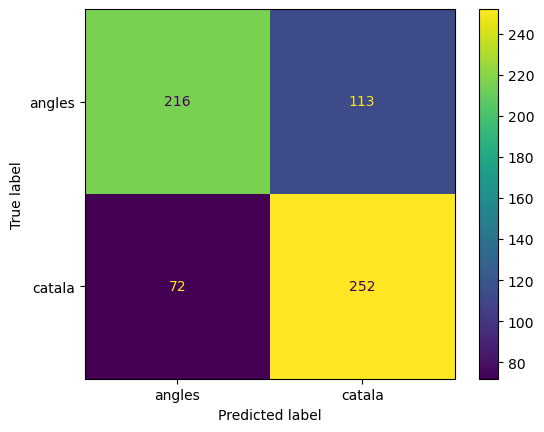

In [147]:
#Re-train Model with Train set
modeloExperimento_4.fit(X_train,y_train)

#Predict with X_test
y_predicted=modeloExperimento_4.predict(X_test)

##Accuracy
print(f"Accuracy: {accuracy_score(y_test,y_predicted):.3f}")

##Precision
print(f"Precision: {precision_score(y_test,y_predicted):.3f}")
#Recall
print(f"Recall: {recall_score(y_test,y_predicted):.3f}")
#Confussion Matrix
cm=confusion_matrix(y_test,y_predicted, labels=modeloExperimento_4.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["angles","catala"])
disp.plot()
plt.show()

### Conclusiones cuarto experimento
En este cuarto experimento, el modelo ha conseguido una __accuracy__ de 0.7, representando una ligera mejora con respecto al primer experimento. Observemos las otras métricas:
- _Precision_: El modelo ha predecido bien un 69% del total de muestras que han sido clasificadas como pertenecientes a la clase positiva (catalán en este caso ya que su valor categórico es el 1).
- _Recall_: En cuanto a la sensibilidad, el modelo ha predecido "bien" el 77% de las muestras la clase positiva, del total real de muestras de la clase positiva.

Con los experimentos 2 y 3 pudimos comprobar que el modelo tiene mayor facilidad para identificar las palabras catalanas debido a que caracteristicas como llevar acentos son decisivas. Sin embargo, para reconocer palabras del inglés no teniamos ninguna característica que fuese decisiva, provocando que para predecir palabras en inglés fuese mas inseguro comparado a identificar palabras en catalán. Con este experimento 4 se han añadido características que son muy buenas para el inglés, y podemos ver que ha compensado esa incertidumbre por lo que el modelo se atreve a etiquetar más palabras como inglesas, mejorando su precisión de manera consistente.